### Import the libaries to be used

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer


### Read in the historic transactions data from a CSV file

In [2]:
df = pd.read_csv(r'C:\Users\parri\Downloads\historic_transactions.csv')

df

,transaction_date,transaction_id,transaction_amount
0,2022-09-17,WeKuSlJdWG0OfbkteXN5,1000
1,2022-09-16,bypPVdMn7iydzNwsYBZl,2000
2,2022-09-15,k7ZEkPT3nV078GbXdjX9,2000
3,2022-09-22,KSKjgWG5f3vFj7mCh6Sf,1500
4,2022-09-16,6NkQBzah4sUEWaO31gQv,1000
...,...,...,...
1104,2023-02-17,O2F5G2YckII4NmNZuDU8,800
1105,2023-02-12,WgxRJC9wIY0zsN6BXfu4,500
1106,2023-02-26,FiCB6ATdu2EzWIaETqSQ,1400
1107,2023-02-23,t5AAcLvpfOL86dPtFQqh,2200


### Data Cleaning

In [3]:
# Convert the transaction date column to a datetime object

df['transaction_date'] = pd.to_datetime(df['transaction_date'])

In [4]:
# Remove NA values

df = df.dropna()

In [5]:
# Remove Duplicates

df.drop_duplicates()

,transaction_date,transaction_id,transaction_amount
0,2022-09-17,WeKuSlJdWG0OfbkteXN5,1000
1,2022-09-16,bypPVdMn7iydzNwsYBZl,2000
2,2022-09-15,k7ZEkPT3nV078GbXdjX9,2000
3,2022-09-22,KSKjgWG5f3vFj7mCh6Sf,1500
4,2022-09-16,6NkQBzah4sUEWaO31gQv,1000
...,...,...,...
1104,2023-02-17,O2F5G2YckII4NmNZuDU8,800
1105,2023-02-12,WgxRJC9wIY0zsN6BXfu4,500
1106,2023-02-26,FiCB6ATdu2EzWIaETqSQ,1400
1107,2023-02-23,t5AAcLvpfOL86dPtFQqh,2200


### Assuming today is the 26th of March

In [6]:
# Set the current date to March 26th
today = datetime(2023, 3, 26)

# Calculate the number of days left until the end of March from 03/26/23
end_of_march = datetime(today.year, 3, 31)
n = (end_of_march - today).days

print("There are", n, "days left until the end of March.")

There are 5 days left until the end of March.


### Comparison of Transaction Volume at {n} Days to End of Month vs Full Month

In [7]:
# Group the data by year and month
df['Date'] = pd.to_datetime(df['transaction_date'])
df['Year'] = df['transaction_date'].dt.year
df['Month'] = df['transaction_date'].dt.month
grouped_data = df.groupby(['Year', 'Month'])

# Create a dictionary to store the total volume for each month
volume_by_month = {}

# Loop through each row of the DataFrame
for index, row in df.iterrows():
    # Extract the month and year from the transaction date
    month = row['transaction_date'].month
    year = row['transaction_date'].year
    
    # Calculate the total volume for this month if it hasn't been calculated yet
    if (month, year) not in volume_by_month:
        volume_by_month[(month, year)] = df.loc[df['transaction_date'].dt.month == month].transaction_amount.sum()
    
    # Check if this transaction occurred n days before the end of its month
    days_before_end_of_month = (row['transaction_date'].replace(day=1) + timedelta(days=32 - row['transaction_date'].day) - end_of_march).days
    if days_before_end_of_month == n:
        # Add the transaction amount to the volume achieved by this point in the month
        volume_by_month[(month, year)] -= row['transaction_amount']

# Calculate the total volume and volume at n days to the end of each month
results = []
growth_rates = []
total_volume_list = []
volume_at_n_days_list = []
month_labels = []
previous_month_volume = None   
for name, group in grouped_data:
    year = name[0]
    month = name[1]
 
    # Determine the last day of the month
    last_day_of_month = datetime(year, month, 1) + relativedelta(day=1, months=1, days=-1)
    
    # Calculate the total volume for the month
    total_volume = group['transaction_amount'].sum()
    total_volume_list.append(total_volume)
    
    volume_at_n_days = group[group['transaction_date'] <= last_day_of_month - timedelta(days=n)]['transaction_amount'].sum()
    volume_at_n_days_list.append(volume_at_n_days)
    results.append({'Month': month, 'Year': year, 'Volume at {} days to end of month'.format(n): volume_at_n_days, 'Total volume': total_volume})

    # Store the month and year labels for the x-axis
    month_labels.append("{}/{}".format(month, year)) 
 

            
    # Calculate the growth rate for this month
    if previous_month_volume is not None and not (month == 3 and year == 2023):
        growth_rate = (total_volume - volume_at_n_days) / volume_at_n_days
        previous_month_full_volume = volume_by_month.get((previous_month, previous_year))
        if previous_month_full_volume:
            previous_month_growth_rate = (total_volume - previous_month_full_volume) / previous_month_full_volume
            growth_rates.append((year, month, growth_rate, previous_month_growth_rate))
        else:
            growth_rates.append((year, month, growth_rate, None))
    else:
        growth_rates.append((year, month, None, None))
        
    previous_month = month
    previous_year = year
    previous_month_volume = total_volume


    


# Create a DataFrame from the results
results_df = pd.DataFrame(results)
results_df.set_index(['Year', 'Month'], inplace=True)
growth_rates_df = pd.DataFrame(growth_rates, columns=['Year', 'Month', 'Growth rate from {}-day volume'.format(n), 'Previous Month Growth Rate'])
results_df = pd.merge(results_df, growth_rates_df, on=['Year', 'Month'], how='left')

# Store the volume for march
march_volume = results_df.loc[(results_df['Year']==2023) & (results_df['Month']==3), 'Total volume'].values[0]

results_df


,Year,Month,Volume at 5 days to end of month,Total volume,Growth rate from 5-day volume,Previous Month Growth Rate
0,2022,9,124350,132350,NaN,NaN
1,2022,10,155600,160900,0.034062,0.215716
2,2022,11,176800,176800,0.000000,0.098819
3,2022,12,287450,289850,0.008349,0.639423
4,2023,1,285850,294150,0.029036,0.014835
5,2023,2,386660,414240,0.071329,0.408261
6,2023,3,359463,359463,NaN,NaN


### Calculate the estimated runrate for the month of March

In [8]:
# load the data into a DataFrame
results_df = results_df.dropna()

# separate the features and target variable
X = results_df[['Previous Month Growth Rate']].values
y = results_df['Growth rate from 5-day volume'].values


# train a linear regression model
regressor = LinearRegression()
regressor.fit(X, y)

# use the model to predict the growth rate for March
march_prev_growth_rate = results_df.loc[(results_df['Year']==2023) & (results_df['Month']==2), 'Previous Month Growth Rate'].values[0]
march_X = [[march_prev_growth_rate]]
march_growth_rate = regressor.predict(march_X)


print(f"Predicted growth rate for March: {march_growth_rate[0]}")

Predicted growth rate for March: 0.030087508992954898


In [9]:
march_estimate = march_volume * (march_growth_rate + 1)

print(f"Predicted Total volume for March: {march_estimate[0]}")

Predicted Total volume for March: 370278.34624513454


### Visualizing the Data

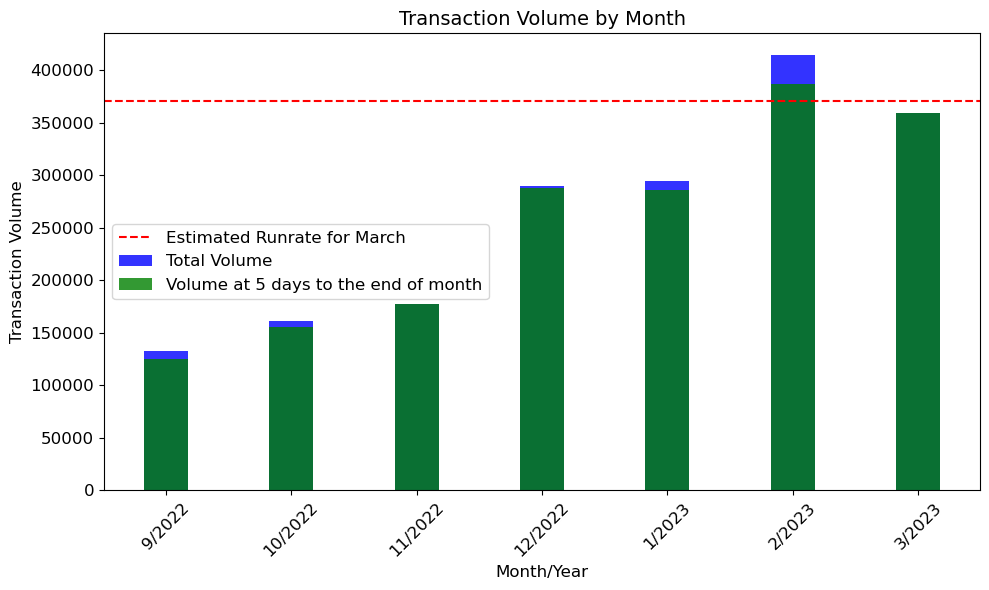

In [18]:
# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
opacity = 0.8
rects1 = ax.bar(month_labels, total_volume_list, bar_width, alpha=opacity, color='b', label='Total Volume')
rects2 = ax.bar(month_labels, volume_at_n_days_list, bar_width, alpha=opacity, color='g', label='Volume at {} days to the end of month'.format(n))

# Add labels and titles to the plot
ax.set_xlabel('Month/Year', fontsize=12)
ax.set_ylabel('Transaction Volume', fontsize=12)
ax.set_title('Transaction Volume by Month', fontsize=14)
ax.legend(fontsize=12)
ax.axhline(y=march_estimate, color='red', linestyle='--', label='Estimated Runrate for March')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
ax.legend(fontsize=12)


fig.tight_layout()
plt.show()
